# Steps for Executing Real-Time Gesture Recognition using TMA Maps of Multi-Channel sEMG Signals

## Importing the Packages

First import the necessary packages. 

In [ ]:
# importing packages

from tma.functions import *
from tma.models.classifiers import fit_NN
from tma.utils import combine_data
from tma.visualization.functions import reduce_dims
from tma.visualization.real_time_visualization import EmgCollectorEmgSignals, PlotEmgSignals, EmgCollectorDiffSignal, PlotDiffSignal
from tma.models.real_time_prediction import EmgCollectorPrediction, Predict
import myo
import h5py
%matplotlib inline

In [2]:
# set the myo sdk (you can get the myo sdk from the following link : https://support.getmyo.com/hc/en-us/articles/360018409792-Myo-Connect-SDK-and-firmware-downloads)

sdk_path = '/Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/sdk/myo.framework/myo'
myo.init(sdk_path)

Then define the EmgLearn object which provides access to the functions that builds up the algorithm

In [3]:
# define the EmgLearn object

el = EmgLearn(fs=200,
              no_channels=8,
              obs_dur=0.400,
              obs_inc=0.100,
              hold_time=5,
              rest_time=5,
              no_replicates=10)

## Plotting the sEMG Signals in Real-Time

It will be good to plot some real-time sEMG signals coming from our MyoArm band first. Place the MyoArm according to the neural position illustrated by the image below and run the following cope snippet.

<img src="gesture10.png" width="50%">

In [ ]:
# plotting the real-time sEMG signals (run after myoband is placed on your arm and is paired with your MacBook / PC)

hub = myo.Hub()
listener = EmgCollectorEmgSignals(n=512)

with hub.run_in_background(listener.on_event):
    PlotEmgSignals(listener, el, gesture_dict=None, conn=None).main()

## Record Training Data

After verifying the signals coming from the MyoArm band, now you can proceed to recording the data that we shall use to training our CNN model later on. First, we shall input some inputs required for data recording. For this example, we use middle flexion, ring flexion, hand closure, v-flexion and pointer.

In [4]:
# Define user inputs

data_save_path = '/Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/data/subject_1001' # where the data should be saved
flexion_gestures = ['M_1', 'R_1', 'HC_1', 'V_1', 'PO_1']  # gesture types

With that, now we can start recording the data. We have set the number of repliacted needed per each gesture type as 10, and therefore, a recording duration of 110s would be sufficient per each gesture type. Before starting to record, poition you arm with the MyoArm band according to the neural position introduced in the section above. During the recording process, perform the corresponding gesture type at 5s, 15s, 25s, ... up until you have perfomed 10 replicates. Hold each performed gesture for a perdiod of roughly 3s and release to come back to the neural position again.

The following code snippet can be used to record 10 replicates from each gesture you specified in the user inputs. At the end of the recording, the recording for each specified gesture type would be saved as a .csv file in the provided directory.
 

In [ ]:
# Record the gestures

el.record_gestures(gestures=flexion_gestures,
                           data_path=data_save_path,
                           recording_time=100,
                           plot=True,
                           sdk_path=sdk_path)

After recording the sEMG recordings for each gesture types, now we can extract the TMA maps around a small neighborhood around each gesture onset. We first specify the onset thresholds and the half width of the neightborhood.

In [5]:
thresh = [3, 5, 5, 4.5, 5]  # onset detection threholds for each gesture type. This can be set manually or by using methods explained in [1].
delta = 0.3  # the half width of the neighborhood selected around each gesture onset points

Now we can create the dataset of the TMA maps.

Sampling from the gesture : M_1
[1080, 3040, 4900, 7100, 9040, 10720, 12680, 15040, 16700, 18740]
stdev :  0.8385269804417441


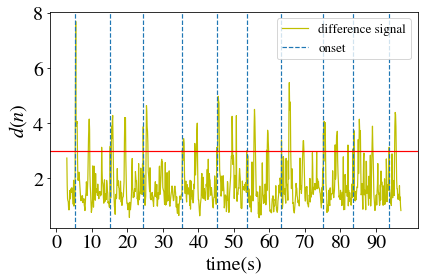

Sampling from the gesture : R_1
[1100, 3080, 5080, 7120, 9100, 11100, 13060, 15100, 17040, 19060]
stdev :  1.2342914137302856


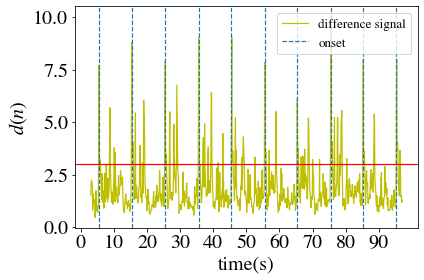

Sampling from the gesture : HC_1
[1100, 3180, 5120, 7140, 9000, 11060, 13060, 15060, 17040, 19100]
stdev :  1.398634408382879


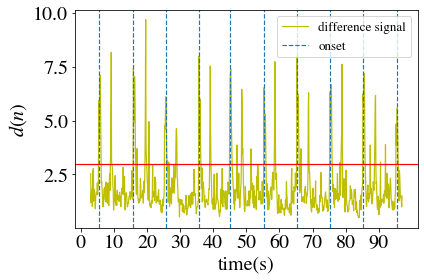

Sampling from the gesture : V_1
[1140, 3080, 5100, 7220, 9120, 11060, 13080, 15080, 17020, 19060]
stdev :  1.2895162244283918


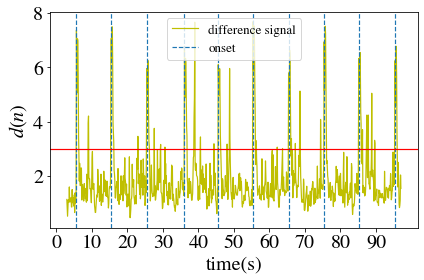

Sampling from the gesture : PO_1
[1080, 3100, 5060, 7140, 9100, 11100, 13080, 15080, 17080, 19020]
stdev :  1.5096265983632196


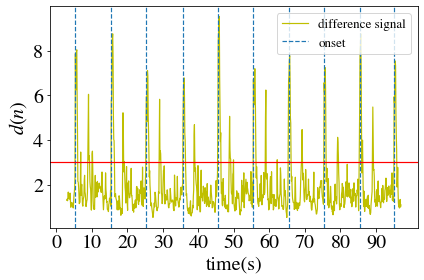

Data Shape :  (1050, 44, 80)
Label Shape :  (1050,)
Labels :  [0. 1. 2. 3. 4.]


In [6]:
# ####################################################
# Create the dataset
# ####################################################

# load the saved recordings
gesture_database = el.load_emg_data(data_path=data_save_path,
                                            gestures=flexion_gestures)

# extract the signal envelopes
filtered_gesture_database = el.filter_signal_database(gesture_database)

X = np.zeros((1, el.H, el.T))  # stores TMA maps
y = np.zeros((1,))  # stores gesture labels of the corresponding TMA maps

for i, gesture in enumerate(list(filtered_gesture_database.keys()), start=0):
    # detects the gesture onset points
    print("Sampling from the gesture : %s" % gesture)
    signal = filtered_gesture_database[gesture]
    trans = el.detect_onsets(signal=signal,
                             obs_inc=0.100,
                             threshold=thresh[i],
                             refractory_period=8,
                             max_dur=97,
                             plot=True)
    for t in trans:
        # stores the TMA maps from a neighborhood defined around each gesture onset points. These maps
        # together with their labels are used as the training data for the classification algorithm
        neighborhood = signal[:, (t - int(delta * el.fs)):(t + int(delta * el.fs))]
        trans_maps = el.get_tma_maps(neighborhood, obs_inc=0.010)
        X = np.concatenate((X, trans_maps), axis=0)
        y = np.concatenate((y, i * np.ones((trans_maps.shape[0],))))

X = X[1:, ...]  # TMA maps
y = y[1:]  # gesture labels assigned for the TMA maps

print("Data Shape : ", X.shape)
print("Label Shape : ", y.shape)
print("Labels : ", np.unique(y))


**Note** : If you are using the method in [1] to set the onset detection thresholds, please plot the onset points and verify their positions. If positions are incorrect, you can plot the difference signal and set
an appropriate threshold manually.

In figures plotted in the above cell, the red horizontal lines stands for the gesture onest threshold imposed for each gesture type.

After the detecting the onsets and obtaining the TMA maps within a neightborhood around the onset, we can save these TMA maps together with their corresponding gesture labels with the following code snippet.

In [ ]:
# saving the TMA map dataset in to .h5 file

dataset_file = h5py.File(data_save_path + '/trans_map_dataset_1.h5')
dataset_file.create_dataset('data', data=X)
dataset_file.create_dataset('label', data=y)
dataset_file.close()

It is recommended to take at least two sets of datasets of TMA maps (each dataset having collected TMA maps from 10 replicates for each gesture types), before training the CNN model.

## Visualizing the TMA Maps

TMA Map for  M_1


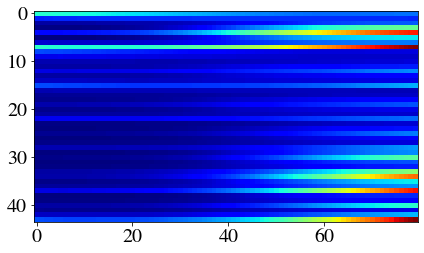

TMA Map for  R_1


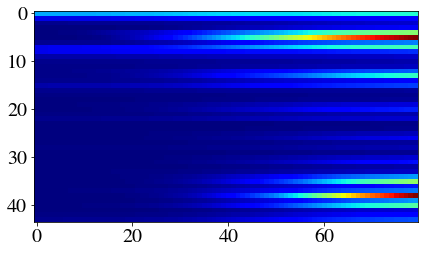

TMA Map for  HC_1


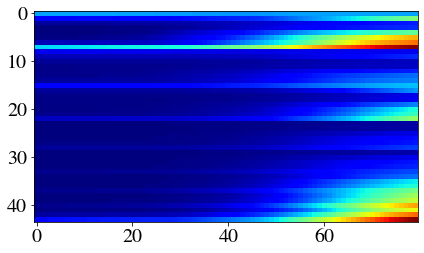

TMA Map for  V_1


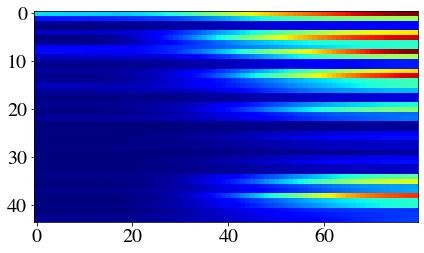

TMA Map for  PO_1


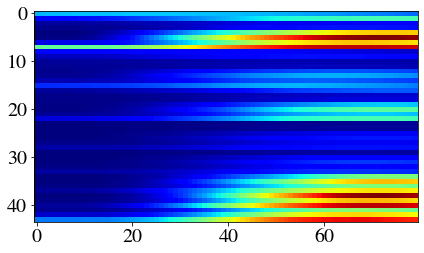

In [7]:
# visualize a TMA maps

dataset = h5py.File(data_save_path + '/trans_map_dataset_1.h5')
tma_maps = np.array(dataset['data'])
labels = np.array(dataset['label'])

for i in range(len(np.unique(labels))):
    print("TMA Map for ", flexion_gestures[i])
    idx = np.where(labels == i)[0][10]
    plt.imshow(np.squeeze(tma_maps[idx]), cmap='jet')
    plt.show()

dataset.close()

## Visualizing the High Dimensional Space of TMA Map Dataset

It'll be interesting to visualizing the high dimensional space before we train our CNN model. To this end, we can flatten each TMA map and reduce dimensions of it using t-sne. This would allow us to see whether there are clusters forming according to the gesture type. (please note that by flattening the TMA maps in to vectors ignores the temporal information contained in the TMA map, therefore, do not come to strict conclusions based on the take t-sne visualization.)

Number of Training Samples :  2100
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.257s...
[t-SNE] Computed neighbors for 2100 samples in 24.885s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 14.716059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.767017


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

[t-SNE] KL divergence after 1000 iterations: 0.253619


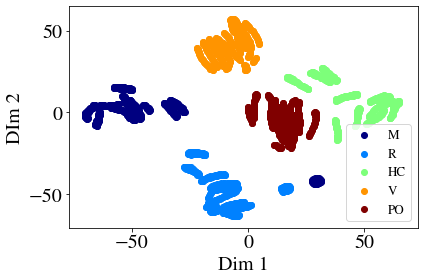

In [16]:
# obtaining the t-sne viualization of TMA map dataset

data_path_1 = '/Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/data/subject_1001/trans_map_dataset_1.h5'
data_path_2 = '/Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/data/subject_1001/trans_map_dataset_2.h5'

X, y = combine_data([data_path_1, data_path_2])

reduce_dims(X=X,
            y=y,
            data_path=None,
            algorithm='tsne',
            perplexity=50,
            labels=['M', 'R', 'HC', 'V', 'PO'])

## Training the CNN Model

Now we can train the CNN model to classify a given TMA map in its respective gesture type. 

In [8]:
# train the CNN

# data path(s)
data_path_1 = '/Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/data/subject_1001/trans_map_dataset_1.h5'
data_path_2 = '/Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/data/subject_1001/trans_map_dataset_2.h5'

# model path (to save the trained model)
model_path = '/Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/models/subject_1001/model/cnn_model_test.h5'

# combine the data from the data path(s)
X, y = combine_data([data_path_1, data_path_2])

# fit a Deep Learning model
fit_NN(X=X,
       y=y,
       data_path=None,
       model_path=model_path,
       model='cnn',
       experiment=el,
       epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
2100/2100 [==============================] - 7s 3ms/step - loss: 1.3941 - categorical_accuracy: 0.5195

Epoch 00001: loss improved from inf to 1.39410, saving model to /Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/models/subject_1001/model/cnn_model_test.h5
Epoch 2/20
2100/2100 [==============================] - 5s 2ms/step - loss: 0.6032 - categorical_accuracy: 0.8614

Epoch 00002: loss improved from 1.39410 to 0.60322, saving model to /Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/models/subject_1001/model/cnn_model_test.h5
Epoch 3/20
2100/2100 [==============================] - 5s 2ms/step - loss: 0.1890 - categorical_accuracy: 0.9614

Epoch 00003: loss improved from 0.60322 to 0.18898, saving model to /Users/ashwin/Current Work/Real-Time Hand Gesture Recognition with TMA Maps/models/subject_1001

## Real-Time Hand Gesture Recognition

After training the model, we can now use it to classify the hand gesture in real-time. Place the MyoArm band according to image in the "Plotting the sEMG Signals in Real-Time" and run the following code snippet to execute real-time hand gesture prediction.

In [ ]:
# real-time hand gesture prediction

hub = myo.Hub()
listener = EmgCollectorPrediction(n=512)
thresh = 7 # onset threshold

gesture_dict = {
        0 : 'Middle_Flexion',
        1 :'Ring_Flexion',
        2 : 'Hand_Closure',
        3 : 'V_Flexion',
        4 : 'Pointer',
        5 : 'Neutral',
        6 : 'No_Gesture'
    }

live = Predict(thresh=thresh
               listener=listener,
               emgLearn=el,
               gesture_dict=gesture_dict,
               cnn_model_path=model_path)

with hub.run_in_background(listener.on_event):
    live.main()

## Plot the Real-Time Difference Signal

Running following code snippet will plot the Difference Signal $d(n)$ in real-time. It would be helpful to set the onset threshold in the real-time hand gesture prediction code.

In [ ]:
# plot the difference signal in real-time

hub = myo.Hub()
listener = EmgCollectorDiffSignal(n=512)

with hub.run_in_background(listener.on_event):
    PlotDiffSignal(listener, el).main()